# 4. Modelling

1. Importing packages and dataset
2. Pre-assesment of multiple regression models
3. Feature selection
4. Hyperparameter tuning for selected models
5. Final model selection and results

### 4.1. Importing packages and dataset

In [1]:
# Import the required packages

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, explained_variance_score

pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [2]:
# Import processed train and test sets and load them in dataframes

# Assign paths variable
X_train_path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/processed/X_train.csv'
X_test_path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/processed/X_test.csv'
y_train_path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/processed/y_train.csv'
y_test_path = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/processed/y_test.csv'

# Load csv in dataframe
X_train = pd.read_csv(X_train_path, index_col=0)
X_test = pd.read_csv(X_test_path, index_col=0)
y_train = pd.read_csv(y_train_path, index_col=0)
y_test = pd.read_csv(y_test_path, index_col=0)

In [3]:
# Import original un-processed dataset for further unscaling and interpretation of data

file = 'C:/Users/javie/OneDrive/Documents/springboard_projects/Capstone-2/data/interim/clean.csv'
orig_df = pd.read_csv(file, index_col=0)

In [4]:
# Check # of columns and rows imported
X_train.shape

(3966, 57)

In [5]:
X_test.shape

(1700, 57)

In [6]:
y_train.head()

,COOL_COST_log,HEAT_COST_log,WATERHEAT_COST_log,ELECT_COST_log,TOT_COST_log
2315,0.669084,0.775234,0.306368,1.206547,1.122772
796,0.081286,0.715753,0.971873,0.317622,0.555368
312,1.304960,0.043174,-0.123977,1.080528,1.089074
1515,0.818738,0.953453,0.411800,0.919769,1.190493
5270,0.957874,0.158600,-0.180249,-0.951668,-0.224427


### 4.2. Pre-assesment of multiple regression models

In this section multiple regression algorithms will be tested with default configuration to obtain a general idea of their performance with our dataset. For this exercise we are not using cross-validation or adjusting any hyperparameter since the objective is simply to understand which algorithm would be the most adequate for this problem.

The algorithms to be tested are the following:
- Linear Regression (OLS)
- Linear Regression with L2 regularization - Ridge
- Linear Regression with L1 regularization - Lasso
- Bagging ensemble method - Random Forest Regressor
- Boosting ensemble method - Gradient Boosting Regressor

In [7]:
# Create fuction to assess performance of different models with our data

def model_performance(reg_models, X_train, X_test, y_train, y_test, original_target_var):
    '''Evaluate regression models performance with default hyperparameters on a dataset'''
    exp_var = []
    mae = []
    
    for model in reg_models:
        m = model()
        m_fit = m.fit(X_train, y_train)
        y_pred = m_fit.predict(X_test)
        
        # Compute explained variance score and mean absolute error
        exp_var.append(round(explained_variance_score(y_test, y_pred),3))
        m = mean_absolute_error(y_test, y_pred)
        
        # Compute sdt and mean from unscaled target variable to perform the inverse transformation of the scaling
        s = float(original_target_var.std())
        u = float(original_target_var.mean())
        # Undo standard scaling and log transformation to get meaningful mean errors
        mae.append(int(np.exp((m*s)+u)-1))

    # Get name of the models
    models = [re.findall(r'\w+', str(i))[-1] for i in reg_models] 
    
    # Create df with results
    df = pd.DataFrame({'model':models, 'exp_var':exp_var, 'mean_abs_error':mae})
    
    return df

In [8]:
# Select the models to test
models = [LinearRegression, Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor]

# Define target variables, one for each type of energy use type plus the combined total
y_train_COOL = y_train[['COOL_COST_log']]
y_train_HEAT = y_train[['HEAT_COST_log']]
y_train_WATER = y_train[['WATERHEAT_COST_log']]
y_train_ELEC = y_train[['ELECT_COST_log']]
y_train_TOT = y_train[['TOT_COST_log']]

y_test_COOL = y_test[['COOL_COST_log']]
y_test_HEAT = y_test[['HEAT_COST_log']]
y_test_WATER = y_test[['WATERHEAT_COST_log']]
y_test_ELEC = y_test[['ELECT_COST_log']]
y_test_TOT = y_test[['TOT_COST_log']]

# Run the tests and store the dfs with the results
r1 = model_performance(models, X_train, X_test, y_train_COOL, y_test_COOL, orig_df['COOL_COST_log'])
r2 = model_performance(models, X_train, X_test, y_train_HEAT, y_test_HEAT, orig_df['HEAT_COST_log'])
r3 = model_performance(models, X_train, X_test, y_train_WATER, y_test_WATER, orig_df['WATERHEAT_COST_log'])
r4 = model_performance(models, X_train, X_test, y_train_ELEC, y_test_ELEC, orig_df['ELECT_COST_log'])
r5 = model_performance(models, X_train, X_test, y_train_TOT, y_test_TOT, orig_df['TOT_COST_log'])

In [9]:
# Merge results and print them

results = r1.merge(r2, on='model').merge(r3, on='model').merge(r4, on='model').merge(r5, on='model')
results.columns = ['model', 
                   'cool_cost_exp_var', 'cool_cost_mae',
                   'heat_cost_exp_var', 'heat_cost_mae',
                   'water_heating_exp_var', 'water_heating_mae',
                   'elect_cost_exp_var', 'elect_cost_mae',
                   'total_cost_exp_var', 'total_cost_mae'
                  ]

#results = results.append(r6)results

results

,model,cool_cost_exp_var,cool_cost_mae,heat_cost_exp_var,heat_cost_mae,water_heating_exp_var,water_heating_mae,elect_cost_exp_var,elect_cost_mae,total_cost_exp_var,total_cost_mae
0,LinearRegression,0.895,137,0.698,488,0.134,386,0.298,1455,0.444,2665
1,Ridge,0.895,137,0.698,488,0.134,386,0.298,1455,0.444,2665
2,Lasso,-0.000,377,0.000,831,0.000,401,0.000,1581,0.000,2995
3,RandomForestRegressor,0.904,129,0.681,488,0.066,393,0.262,1470,0.411,2696
4,GradientBoostingRegressor,0.907,131,0.707,478,0.118,388,0.287,1456,0.445,2661


In [10]:
# Print median values for each of the target variables for comparison

k = orig_df[['COOL_COST_log', 'HEAT_COST_log', 'WATERHEAT_COST_log', 'ELECT_COST_log', 'TOT_COST_log']]

median_val = pd.DataFrame(np.exp(k.describe().iloc[5, :])-1, index=None).rename(columns={'50%':'median'})
median_val.reset_index(inplace=True)
median_val

,index,median
0,COOL_COST_log,146.584999
1,HEAT_COST_log,400.584984
2,WATERHEAT_COST_log,236.394997
3,ELECT_COST_log,1020.404844
4,TOT_COST_log,1997.445000


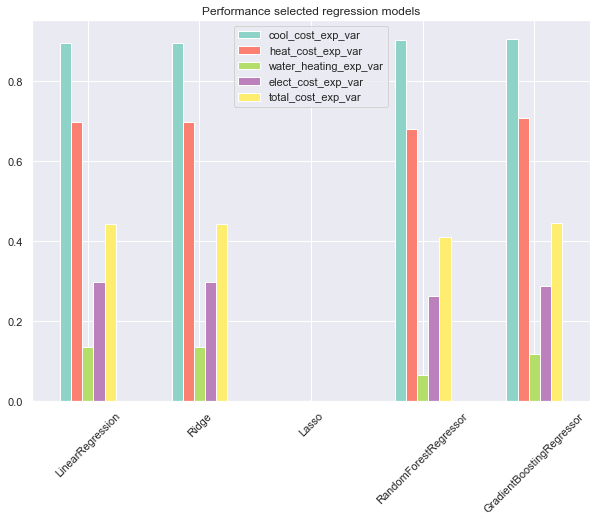

In [11]:
# Plot explained variance results

expl_var_results = results[['model', 'cool_cost_exp_var', 'heat_cost_exp_var', 
                            'water_heating_exp_var', 'elect_cost_exp_var', 'total_cost_exp_var']]
                           
expl_var_results.plot.bar(x='model', cmap='Set3', figsize=(10,7))
plt.title('Performance selected regression models', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(loc='upper center')
plt.tight_layout
plt.show()

__Conclusions for this section:__

Initial results show that the Gradient Boosting ensemble algorithm yields the best explained variance score in Cooling, Heating and Total cost target variables, whereas Ridge Regression algorithm stands out as the best performer for Water Heating and Other Electricity Costs. However, all algorithms tested scored rather low for Water-Heating-Costs and Other-Electrical-Costs, which means that those response variables are hardly explained by any algorithm.

Besides, the best model explains ~45.4% of the target variable variance which is roughly an average of the other four compounding response variables. 

The most remarkable outcome of this assessment is that the spread of the mean error is so high compared to the median value that became hardly usefull for the objective of this project. 

Regardless of this circumstances, in next sections we will select the most relevant features and adjust the model's  hyperparameters to try to reduce the bias.

We will work with Ridge algorithm for Water Heating and Other Electricity Costs and Gradient Boosting for the other target variables.

### 4.3. Feature selection

Once we know which model will use to predict each response variable, we will optimize the feature space by removing higly correlated columns and features which are irrelevant for the regression model. 

Firstly, we will check and remove any highly correlated features to reduce dimensionality: 

In [12]:
# Create function to select and remove highly correlated features

def remove_corr_feat(df):
    '''Selects and remove highly correlated features'''
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of the matrix, since it is symmetric
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
    
    # Select columns with correlation coefficient higher than 0.95
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    
    # Drop correlated features
    dfo = df.drop(to_drop, axis=1)
    
    return dfo   

In [13]:
# Remove highly correlated features from train set

X_train = remove_corr_feat(X_train)
X_train.shape

(3966, 55)

In [14]:
# Remove highly correlated features from test set

X_test = remove_corr_feat(X_test)
X_test.shape

(1700, 55)

Now, we will select features based on its mean absolute error. 

We will achieve this by using a Recursive Feature Elimination algorithm which automatically tune of the number of features selected with cross-validation.

We will perform this procedure for each target variable:

In [15]:
# Import package 
from sklearn.feature_selection import RFECV

# Define fucntion for feature selection
def cv_feature_selection(estimator, X, y):
    '''Selectcs optimal features based on mean absolute error'''
    rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    rfecv.fit(X, y)

    rfecv_mask = rfecv.get_support()
    
    rfecv_features = [] 
    for bool, feature in zip(rfecv_mask, X_train.columns):
        if bool:
            rfecv_features.append(feature)

    return rfecv_features

- Feature selection for *Cooling Costs*:

In [16]:
# Instantiate regressor
reg = GradientBoostingRegressor()

# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_COOL)

print('Optimal number of features :', len(sel_features))

X_train_COOL = X_train[sel_features]
X_test_COOL = X_test[sel_features]

Optimal number of features : 29


- Feature selection for *Heating Costs*:

In [17]:
# Instantiate regressor
reg = GradientBoostingRegressor()

# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_HEAT)

print('Optimal number of features :', len(sel_features))

X_train_HEAT = X_train[sel_features]
X_test_HEAT = X_test[sel_features]

Optimal number of features : 33


- Feature selection for *Water Heating Costs*:

In [18]:
# Instantiate regressor
reg = Ridge()

# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_WATER)

print('Optimal number of features :', len(sel_features))

X_train_WATER = X_train[sel_features]
X_test_WATER = X_test[sel_features]

Optimal number of features : 27


- Feature selection for *Other Electricity Costs*:

In [19]:
# Instantiate regressor
reg = Ridge()

# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_ELEC)

print('Optimal number of features :', len(sel_features))

X_train_ELEC = X_train[sel_features]
X_test_ELEC = X_test[sel_features]

Optimal number of features : 27


- Feature selection for *Total Utility Costs*:

In [20]:
# Instantiate regressor
reg = GradientBoostingRegressor()

# Select features for cooling costs target variable
sel_features = cv_feature_selection(reg, X_train, y_train_TOT)

print('Optimal number of features :', len(sel_features))

X_train_TOT = X_train[sel_features]
X_test_TOT = X_test[sel_features]

Optimal number of features : 30


### 4.4. Hyperparameter tuning for selected models

In this section, we will tune the hyperparameters of the Gradient Boosting and Ridge algorithms to find the best model for each of the variables. To do this we will use a grid search algorithm with cross-validation.

__Gradient Boosting Regressor__

The following parameters will be tested and adjusted:
- Max Depth
- Number of Estimators
- Learning Rate

__Ridge Regression algorithm__

L2 regularization coefficient will be adjusted: alpha

In [21]:
# Import GridSearch
from sklearn.model_selection import GridSearchCV

In [22]:
# Create function for grid search and cross-validation

def best_config(model, param_grid, X_train, y_train):
    '''Runs a grid search with cross-validation for selected model and datasets'''
    estimator = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    estimator_fit = estimator.fit(X_train, y_train)
    
    # Get 5 best models and their scores
    r = pd.DataFrame(estimator_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]
    return r

- Hyperparameter tune for *Cooling Costs*:

In [23]:
# Instantiate the regressor
gbr = GradientBoostingRegressor()

# Select hyperparameters to tune 
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'max_depth': [2, 3, 4], 
              'n_estimators': [100, 200, 300]
             }

# Get best hyperparams and score
best_config(gbr, param_grid, X_train_COOL, y_train_COOL)[['params', 'mean_test_score']]

,params,mean_test_score
15,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}",0.908627
13,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}",0.908243
14,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}",0.907736
16,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}",0.907415
11,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}",0.907350


- Hyperparameter tune for *Heating Costs*:

In [24]:
# Instantiate the regressor
gbr = GradientBoostingRegressor()

# Select hyperparameters to tune 
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'max_depth': [2, 3, 4], 
              'n_estimators': [100, 200, 300]
             }

# Get best hyperparams and score
best_config(gbr, param_grid, X_train_HEAT, y_train_HEAT)[['params', 'mean_test_score']]

,params,mean_test_score
10,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}",0.674374
11,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}",0.674095
12,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.673060
15,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}",0.671496
9,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}",0.671334


- Hyperparameter tune for *Water Heating Costs*:

In [25]:
# Instantiate the regressor
ridge = Ridge()

# Select hyperparameters to tune 
param_grid = {'alpha':np.arange(1, 50)}

best_config(ridge, param_grid, X_train_WATER, y_train_WATER)[['params', 'mean_test_score']]

,params,mean_test_score
15,{'alpha': 16},0.135860
14,{'alpha': 15},0.135860
16,{'alpha': 17},0.135859
13,{'alpha': 14},0.135859
17,{'alpha': 18},0.135858


- Hyperparameter tune for *Other Electricity Costs*:

In [26]:
# Instantiate the regressor
ridge = Ridge()

# Select hyperparameters to tune 
param_grid = {'alpha':np.arange(1, 50)}

best_config(ridge, param_grid, X_train_ELEC, y_train_ELEC)[['params', 'mean_test_score']]

,params,mean_test_score
47,{'alpha': 48},0.259075
46,{'alpha': 47},0.259075
48,{'alpha': 49},0.259075
45,{'alpha': 46},0.259075
44,{'alpha': 45},0.259075


- Hyperparameter tune for *Total Utility Costs*:

In [27]:
# Instantiate the regressor
gbr = GradientBoostingRegressor()

# Select hyperparameters to tune 
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'max_depth': [2, 3, 4], 
              'n_estimators': [100, 200, 300]
             }

# Get best hyperparams and score
best_config(gbr, param_grid, X_train_TOT, y_train_TOT)[['params', 'mean_test_score']]

,params,mean_test_score
12,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.379277
11,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}",0.378313
10,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}",0.377948
13,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}",0.373264
15,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}",0.370965


### 4.5. Final model selection and results

In this section, we will run the final model selection for each of the target variables and review the results

In [28]:
# Create fuction to assess performance of different models with our data

def model_scoring(y_test, y_pred, original_target_var):
    '''Get explained variance and mean absolute error with real unscaled values'''
        
    # Compute explained variance score and mean absolute error
    exp_var = round(explained_variance_score(y_test, y_pred),3)
    mae = mean_absolute_error(y_test, y_pred)
        
    # Compute sdt and mean from unscaled target variable to perform the inverse transformation of the scaling
    s = float(original_target_var.std())
    u = float(original_target_var.mean())
    
    # Undo standard scaling and log transformation and reassign to mae 
    mae = int(np.exp((mae*s)+u)-1)
    
    return exp_var, mae

In [29]:
# Create empty lists to store results

exp_var = []
mae = []
feat = ['cooling cost', 'heating cost', 'water heating cost', 'other electricity cost', 'total utility cost']

- Final model for *Cooling Cost* prediction:

In [30]:
# Instantiate predictor
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=4, n_estimators=100)

# Fit and predict
gbr_fit = gbr.fit(X_train_COOL, y_train_COOL)
y_pred = gbr_fit.predict(X_test_COOL)

# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_COOL, y_pred, orig_df['COOL_COST_log'])

# Store results in lists
exp_var.append(ev)
mae.append(m)

- Final model for *Heating Cost* prediction:

In [31]:
# Instantiate predictor
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=100)

# Fit and predict
gbr_fit = gbr.fit(X_train_HEAT, y_train_HEAT)
y_pred = gbr_fit.predict(X_test_HEAT)

# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_HEAT, y_pred, orig_df['HEAT_COST_log'])

# Store results in lists
exp_var.append(ev)
mae.append(m)

- Final model for *Water Heating Cost* prediction:

In [32]:
# Instantiate predictor
ridge = Ridge(alpha=16)

# Fit and predict
ridge_fit = ridge.fit(X_train_WATER, y_train_WATER)
y_pred = ridge_fit.predict(X_test_WATER)

# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_WATER, y_pred, orig_df['WATERHEAT_COST_log'])

# Store results in lists
exp_var.append(ev)
mae.append(m)

- Final model for *Other Electricity Cost* prediction:

In [33]:
# Instantiate predictor
ridge = Ridge(alpha=48)

# Fit and predict
ridge_fit = ridge.fit(X_train_ELEC, y_train_ELEC)
y_pred = ridge_fit.predict(X_test_ELEC)

# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_ELEC, y_pred, orig_df['ELECT_COST_log'])

# Store results in lists
exp_var.append(ev)
mae.append(m)

- Final model for *Total Cost* prediction:

In [34]:
# Instantiate predictor
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=100)

# Fit and predict
gbr_fit = gbr.fit(X_train_TOT, y_train_TOT)
y_pred = gbr_fit.predict(X_test_TOT)

# Get explained variance and mean absolute error
ev, m = model_scoring(y_test_TOT, y_pred, orig_df['TOT_COST_log'])

# Store results in lists
exp_var.append(ev)
mae.append(m)

In [35]:
pd.DataFrame({'features':feat, 'explained variance':exp_var, 'MAE':mae}).join(median_val['median'], how='left')

,features,explained variance,MAE,median
0,cooling cost,0.910,129,146.584999
1,heating cost,0.705,479,400.584984
2,water heating cost,0.136,385,236.394997
3,other electricity cost,0.301,1453,1020.404844
4,total utility cost,0.444,2660,1997.445000
